# BME280 Sensor Analysis Session
Welcome to the BME280 sensor data analysis session using python

In [1]:
# Import packages
import matplotlib.pyplot as plt
import pandas as pd
import cartopy
import datetime
from datetime import datetime

# I. Prepare the data

In [2]:
# Merge multiple .txt files (GPS data) into one file

# #import glob
# import os

# # remote gps.txt if exists
# if os.path.exists("./Harry/gps.txt"):
#     # Remove the file
#     os.remove("./Harry/gps.txt")

# read_files = glob.glob("./Harry/*.txt")
# header = "type,date time,latitude,longitude,accuracy(m),altitude(m),geoid_height(m),speed(m/s),bearing(deg),sat_used,sat_inview,name,desc".encode('utf-8')

# with open("./Harry/gps_harry.txt", "wb") as outfile:
#     # Write a header
#     outfile.write(header + b"\n")
#     for f in read_files:
#         with open(f, "rb") as infile:
#             # Skip the first line
#              next(infile)
#              # Write the rest of the file to the result file
#             for line in infile:
#                 outfile.write(line)

Read in appropriate files and datasets

In [3]:
# Read in files
file_A = open("Harry.CSV")
file_B = open("Anna.CSV")
gps_A = open("gps_harry.txt")
gps_B = open("gps_anna.txt")
# Open files as datasets
dataset_A = pd.read_csv(file_A)
gps_data_A = pd.read_csv(gps_A)
dataset_B = pd.read_csv(file_B)
gps_data_B = pd.read_csv(gps_B)

Prepare the data - remove unnecessary subheaders and columns

In [4]:
dataset_A = dataset_A[dataset_A["Date"] != "Date"]
gps_data_A = gps_data_A.drop(columns=['type','geoid_height(m)','speed(m/s)','bearing(deg)','sat_used','sat_inview','name','desc'])

dataset_B = dataset_B[dataset_B["Date"] != "Date"]
gps_data_B = gps_data_B.drop(columns=['type','geoid_height(m)','speed(m/s)','bearing(deg)','sat_used','sat_inview','name','desc'])

We need to merge the datasets due to not recording GPS on the sensors, we will also have to make some data conversions to make plotting and analysis easier:

Need to convert datetime columns to datetime objects:
Converts into the format: yyyy-mm-dd hh:mm:ss

In [5]:
dataset_A["Datetime"] = pd.to_datetime(dataset_A['Date'] + " " + dataset_A["Time"], format='%d/%m/%Y %H:%M:%S')
gps_data_A["date time"] = pd.to_datetime(gps_data_A['date time'], format='%d/%m/%Y %H:%M:%S')

dataset_A['Time'] = dataset_A['Datetime'].dt.time
dataset_A['Date'] = dataset_A['Datetime'].dt.date

dataset_B["Datetime"] = pd.to_datetime(dataset_B['Date'] + " " + dataset_B["Time"], format='%d/%m/%Y %H:%M:%S')
gps_data_B["date time"] = pd.to_datetime(gps_data_B['date time'], format='%d/%m/%Y %H:%M:%S')

dataset_B['Time'] = dataset_B['Datetime'].dt.time
dataset_B['Date'] = dataset_B['Datetime'].dt.date

We now need to sort the data to ensure it is chronological order:

In [6]:
dataset_A_sorted = dataset_A.sort_values('Datetime')
gps_data_A_sorted = gps_data_A.sort_values('date time')

dataset_B_sorted = dataset_B.sort_values('Datetime')
gps_data_B_sorted = gps_data_B.sort_values('date time')

Merge through by matching nearest datetime values. This tags the latitude and longitude columns onto your data array

In [7]:
data_A = pd.merge_asof(dataset_A_sorted, gps_data_A_sorted, left_on='Datetime', right_on='date time', direction='nearest', tolerance=pd.Timedelta(minutes=5))
data_B = pd.merge_asof(dataset_B_sorted, gps_data_B_sorted, left_on='Datetime', right_on='date time', direction='nearest', tolerance=pd.Timedelta(minutes=5))

Ignore the data where the difference between sensor and GPS datetimes is too large (more than 5min)

In [8]:
data_A = data_A[data_A["date time"].notna()]
data_B = data_B[data_B["date time"].notna()]

Have a look at the data

In [9]:
data_A

,Date,Time,Temperature(C),Pressure(hPa),Altitude(m),Humidity(%),Datetime,date time,latitude,longitude,accuracy(m),altitude(m)
26,2024-03-12,15:53:00,25.01,1018.53,-43.61,56.09,2024-03-12 15:53:00,2024-03-12 15:57:44,28.030542,-16.561455,8.0,80.0
27,2024-03-12,15:54:00,24.83,1018.56,-44.09,57.88,2024-03-12 15:54:00,2024-03-12 15:57:44,28.030542,-16.561455,8.0,80.0
28,2024-03-12,15:55:00,24.3,1018.5,-43.61,58.02,2024-03-12 15:55:00,2024-03-12 15:57:44,28.030542,-16.561455,8.0,80.0
29,2024-03-12,15:56:00,24.18,1018.43,-43.04,59.04,2024-03-12 15:56:00,2024-03-12 15:57:44,28.030542,-16.561455,8.0,80.0
30,2024-03-12,15:57:00,22.62,1018.49,-43.57,63.32,2024-03-12 15:57:00,2024-03-12 15:57:44,28.030542,-16.561455,8.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1585,2024-03-20,10:12:00,16.17,951.97,523.19,81.03,2024-03-20 10:12:00,2024-03-20 10:12:00,28.757895,-17.780957,2.8,665.0
1586,2024-03-20,10:13:00,16.2,951.23,529.66,81.82,2024-03-20 10:13:00,2024-03-20 10:13:00,28.757452,-17.781002,2.7,663.0
1587,2024-03-20,10:14:00,16.11,950.91,532.48,81.54,2024-03-20 10:14:00,2024-03-20 10:14:00,28.757063,-17.781043,3.0,667.0
1588,2024-03-20,10:15:00,16.05,950.15,539.12,82.22,2024-03-20 10:15:00,2024-03-20 10:15:00,28.756690,-17.781280,2.6,672.0


For daily cycles, we need to convert the time into plottable numeric data, and convert other columns into numeric data:

In [10]:
data_A['time_numeric'] = data_A['Time'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)

numeric_cols = data_A.columns.difference(['Date', 'Time', 'Datetime', 'date time'])  # Exclude datetime column
data_A[numeric_cols] = data_A[numeric_cols].apply(pd.to_numeric)

data_B['time_numeric'] = data_B['Time'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)

numeric_cols = data_B.columns.difference(['Date', 'Time', 'Datetime', 'date time'])  # Exclude datetime column
data_B[numeric_cols] = data_A[numeric_cols].apply(pd.to_numeric)

### Daily mean data
Doing the same as we did for time but for date allows us to compute daily means etc.

In [11]:
# We can now calculate the mean temperature, etc. of our data by grouping by the day it was measured on:
day_temp_A = data_A.groupby('Date')['Temperature(C)'].mean()
day_temp_B = data_B.groupby('Date')['Temperature(C)'].mean()
# This returns a series with the index being the day and the values are the temperatures
day_humid_A = data_A.groupby('Date')['Humidity(%)'].mean()
day_humid_B = data_B.groupby('Date')['Humidity(%)'].mean()
day_pressure_A = data_A.groupby('Date')['Pressure(hPa)'].mean()
day_pressure_B = data_B.groupby('Date')['Pressure(hPa)'].mean()

# II. Figure Plotting

### 1. Simple time series - Temperature change over the whole trip

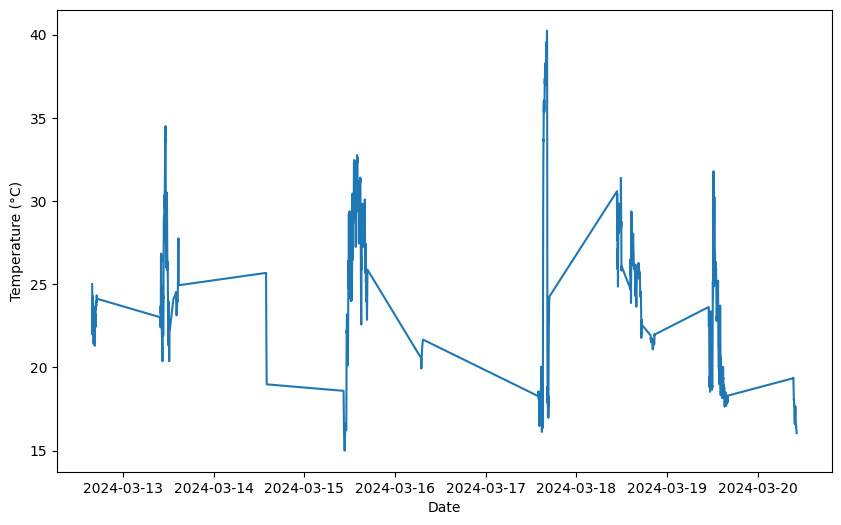

In [12]:
# This figure plots a timeseries of temperature
# Start figure
plt.figure(figsize=(10,6))
# Tell it what to plot
plt.plot(data_A['Datetime'], data_A['Temperature(C)'])
# You can plot a specific date only:
#plot_date = pd.Timestamp('2024-03-15')
#plt.plot(data[data['Date'] == plot_date]['Datetime'], data[data['Date'] == plot_date]['Temperature(C)'])

# Label axes
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
# to save the figure, delete the hashtag, re-run and change name from timeseries.png
# plt.savefig('timeseries.png', dpi = 300)
plt.show()

**Task**: Check the temperature timeseries for the second dataset

### 2. Daily patterns over the whole trip

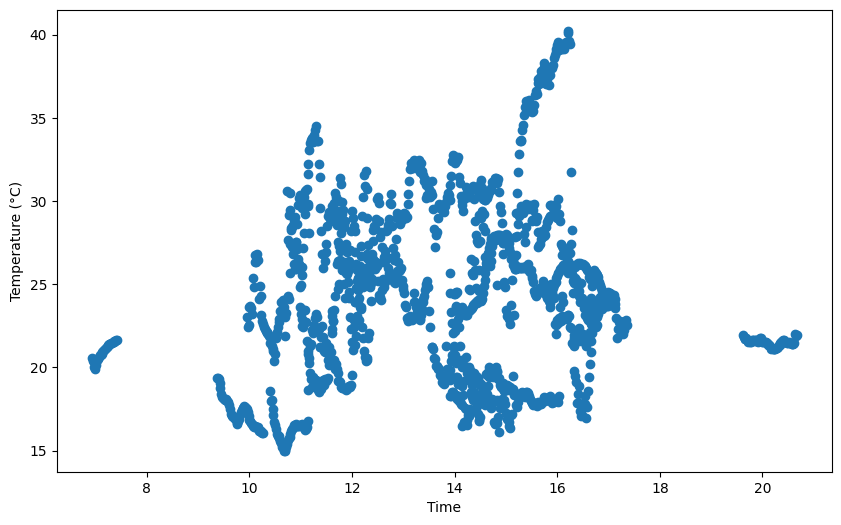

In [13]:
# This figure plots a timeseries of temperature but with the day component removed
# Start figure
plt.figure(figsize=(10,6))
# We can change the type of plot if necessary: (I've changed this one to a scatter)
plt.scatter(data_A['time_numeric'], data_A['Temperature(C)'])
# Label axes
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
# to save the figure, delete the hashtag, re-run and change name from timeseries.png
# plt.savefig('timeseries.png', dpi = 300)
plt.show()

**Task**: Discuss whether this is a useful information :)

### 3. Plot daily average for the entire trip

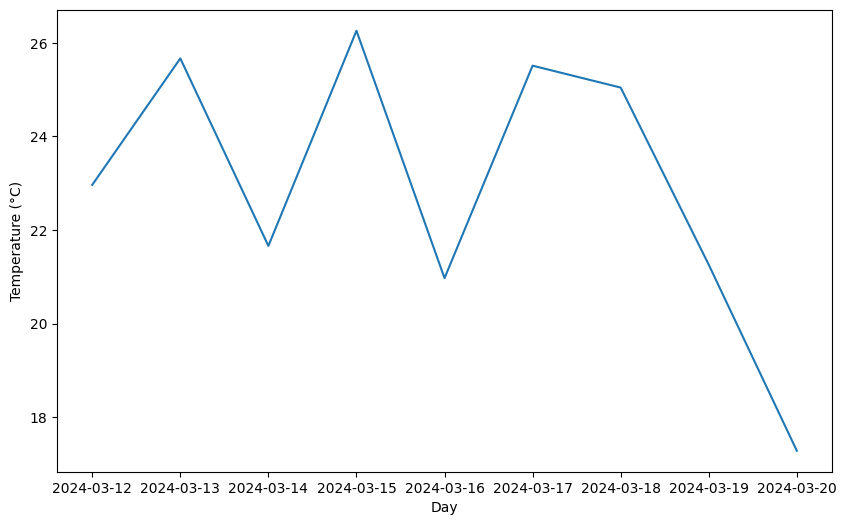

In [14]:
# This figure plots a timeseries of temperature but as a daily mean
# Start figure
plt.figure(figsize=(10,6))
# tell it what to plot
plt.plot(day_temp_A.index, day_temp_A)
# label axes
plt.xlabel('Day')
plt.ylabel('Temperature (°C)')
# to save the figure, delete the hashtag, re-run and change name from timeseries.png
# plt.savefig('timeseries.png', dpi = 300)
plt.show()

**Task**: Produce plots for pressure and humidity

### 4. Compare data between sensors (Anna vs Harry)

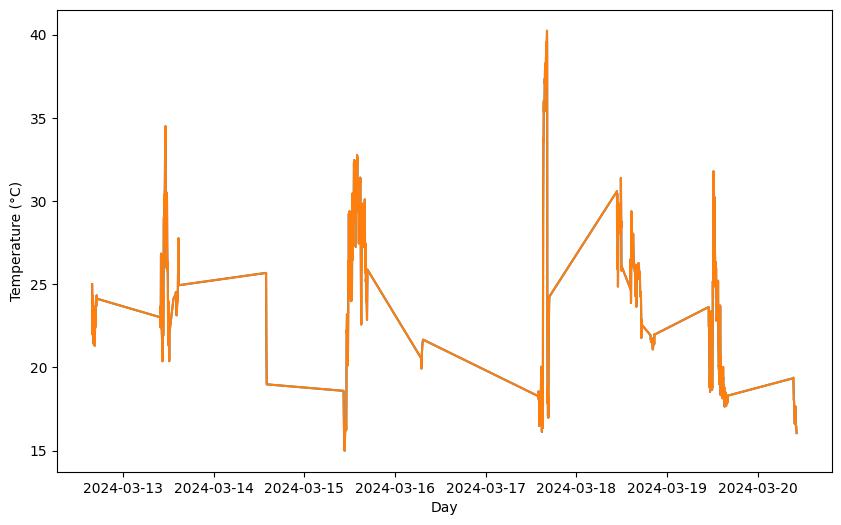

In [15]:
# This figure plots a timeseries of temperature but as a daily mean
# Start figure
plt.figure(figsize=(10,6))
# tell it what to plot
exclude_dates = [pd.Timestamp('2024-03-13'), pd.Timestamp('2024-03-15')]
# Anna data
plt.plot(
    data_A[~data_A['Date'].isin(exclude_dates)]['Datetime'],
    data_A[~data_A['Date'].isin(exclude_dates)]['Temperature(C)'])
# Harry data
plt.plot(
    data_A[~data_A['Date'].isin(exclude_dates)]['Datetime'],
    data_A[~data_A['Date'].isin(exclude_dates)]['Temperature(C)'])
# label axes
plt.xlabel('Day')
plt.ylabel('Temperature (°C)')
# to save the figure, delete the hashtag, re-run and change name from timeseries.png
# plt.savefig('timeseries.png', dpi = 300)
plt.show()


**Task**: Investigate the mismatch at a finer temporal resolution

### 5. Maps

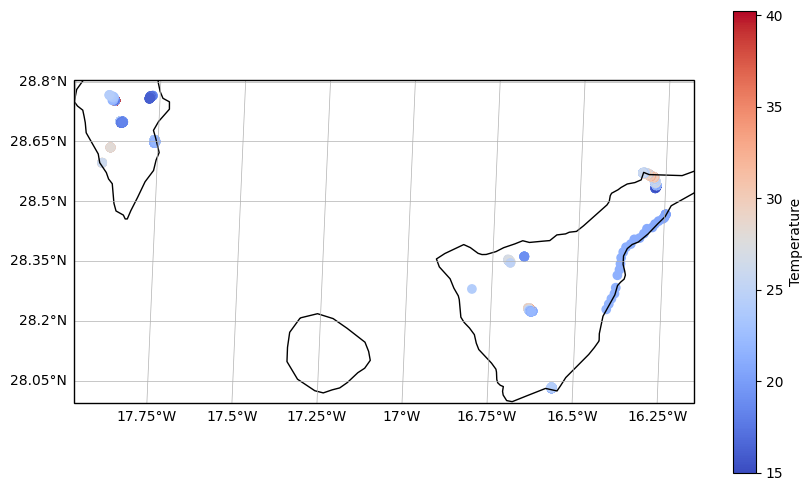

In [16]:
# This figure maps temperature data on a scatterplot for our fieldwork
# Start figure
plt.figure(figsize=(10, 6))
# Setup axes with map projection
ax = plt.axes(projection = cartopy.crs.Robinson())
# Add coastlines
ax.coastlines(resolution = '10m')
# Add scattered data
sc = ax.scatter(data_A['longitude'], data_A['latitude'], c= data_A['Temperature(C)'], cmap = 'coolwarm', marker = 'o', transform = cartopy.crs.PlateCarree())
# Setup colorbar
cbar = plt.colorbar(sc, ax = ax, label = 'Temperature')
# Figure outline
ax.spines['geo'].set_linewidth(1)
# Setup gridlines
gl = ax.gridlines(linewidth=0.5, draw_labels=True, crs=cartopy.crs.PlateCarree())
# Remove right side and top of figure labels
gl.right_labels = False
gl.top_labels = False
# to save the figure, delete the hashtag and re-run
# plt.savefig('map.png', dpi = 300)
plt.show()

**Task**: Create maps for humidity and pressure.

**Task**: Zoom in to a specific activity (choose an activity/day like in Plot 1)